# 📊 Inventory Optimization Project – EDA & Feature Engineering
This notebook performs detailed EDA, feature engineering, and visualization using data from the `inventory_forecasting.csv` stored in MySQL as `fact_inventory`, `dim_store`, and `dim_product` tables.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Correct password with URL encoding (@ → %40)
user = 'root'
password = 'Prem%40777'  # URL encoded
host = 'localhost'
port = '3306'
database = 'Adv_sql_project'

# Create SQLAlchemy engine
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}")

In [6]:
fact_inventory = pd.read_sql("SELECT * FROM fact_inventory", engine)
dim_store = pd.read_sql("SELECT * FROM dim_store", engine)
dim_product = pd.read_sql("SELECT * FROM dim_product", engine)

In [7]:
print("🧾 Fact Table Preview:")
display(fact_inventory.head())

print("\n🧾 Shape of fact_inventory:", fact_inventory.shape)
print("\n📑 Data Types:\n")
display(fact_inventory.dtypes)

print("\n📊 Null Value Summary:")
display(fact_inventory.isnull().sum())

🧾 Fact Table Preview:


,date,store_id,product_id,region,inventory_level,units_sold,units_ordered,demand_forecast,price,discount,weather_condition,holiday_promotion,competitor_pricing,seasonality
0,2022-01-01,S001,P0016,East,189,127,125,150.47,90.78,0.0,Rainy,0,84.16,Winter
1,2022-01-01,S001,P0017,South,70,64,68,92.68,40.64,0.0,Cloudy,0,36.99,Winter
2,2022-01-01,S001,P0031,West,75,48,39,68.62,13.99,20.0,Rainy,0,12.67,Winter
3,2022-01-01,S001,P0046,South,139,117,110,128.42,64.72,5.0,Rainy,0,67.55,Winter
4,2022-01-01,S001,P0057,East,142,115,112,118.46,63.14,10.0,Snowy,0,61.15,Winter



🧾 Shape of fact_inventory: (109500, 14)

📑 Data Types:



date                   object
store_id               object
product_id             object
region                 object
inventory_level         int64
units_sold              int64
units_ordered           int64
demand_forecast       float64
price                 float64
discount              float64
weather_condition      object
holiday_promotion       int64
competitor_pricing    float64
seasonality            object
dtype: object


📊 Null Value Summary:


date                  0
store_id              0
product_id            0
region                0
inventory_level       0
units_sold            0
units_ordered         0
demand_forecast       0
price                 0
discount              0
weather_condition     0
holiday_promotion     0
competitor_pricing    0
seasonality           0
dtype: int64

In [8]:
# Replace 0 and 1 in 'holiday_promotion' with 'No' and 'Yes'
fact_inventory['holiday_promotion'] = fact_inventory['holiday_promotion'].replace({0: 'No', 1: 'Yes'})

# Convert discount to integer (remove .0 and make it whole number)
fact_inventory['discount'] = fact_inventory['discount'].astype(int)

# Preview the changes
fact_inventory[['holiday_promotion', 'discount']].head()

,holiday_promotion,discount
0,No,0
1,No,0
2,No,20
3,No,5
4,No,10


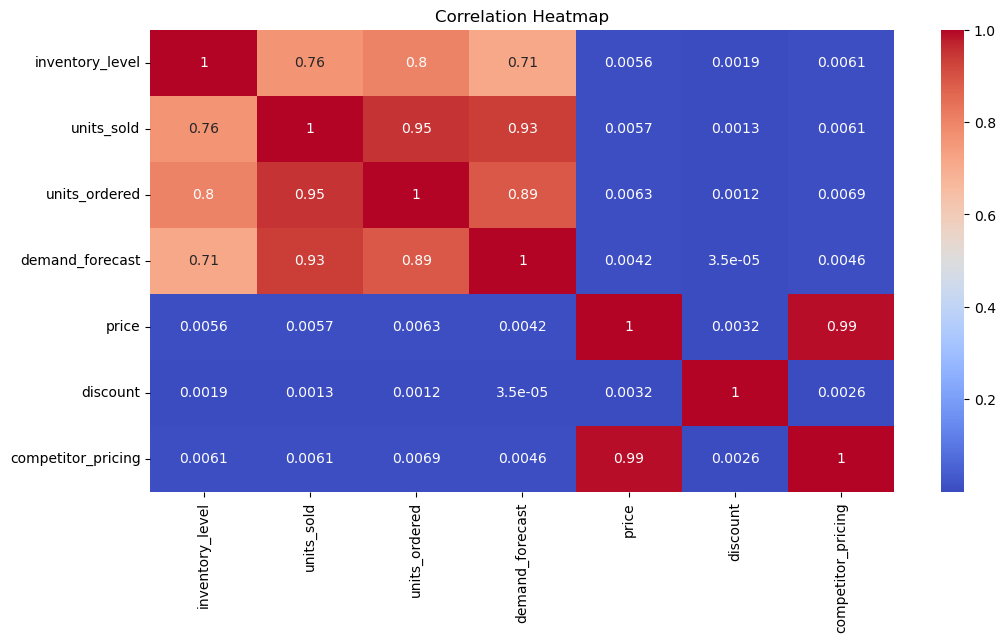

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(fact_inventory.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [10]:
# Create new columns based on cleaned lowercase column names
fact_inventory['inventory_gap'] = fact_inventory['inventory_level'] - fact_inventory['units_sold']
fact_inventory['forecast_error'] = abs(fact_inventory['demand_forecast'] - fact_inventory['units_sold'])
fact_inventory['forecast_accuracy'] = 1 - (fact_inventory['forecast_error'] / (fact_inventory['demand_forecast'] + 1e-5))

# Preview
fact_inventory[['inventory_gap', 'forecast_error', 'forecast_accuracy']].head()

,inventory_gap,forecast_error,forecast_accuracy
0,62,23.47,0.844022
1,6,28.68,0.690548
2,27,20.62,0.699505
3,22,11.42,0.911073
4,27,3.46,0.970792


In [11]:
# Group by holiday promotion and calculate average units sold
holiday_analysis = fact_inventory.groupby('holiday_promotion')['units_sold'].mean().reset_index()
holiday_analysis.columns = ['holiday_promotion', 'avg_units_sold']
holiday_analysis

,holiday_promotion,avg_units_sold
0,No,93.839904
1,Yes,113.055545


In [12]:
# Inventory gap average per store
gap_by_store = fact_inventory.groupby('store_id')['inventory_gap'].mean().reset_index()
gap_by_store.columns = ['store_id', 'avg_inventory_gap']
gap_by_store.sort_values(by='avg_inventory_gap', ascending=False).head()

,store_id,avg_inventory_gap
1,S002,49.381416
3,S004,49.188904
0,S001,48.986347
2,S003,48.698721
4,S005,48.652603


In [13]:
# Forecast accuracy by store
accuracy_by_store = fact_inventory.groupby('store_id')['forecast_accuracy'].mean().reset_index()
accuracy_by_store.columns = ['store_id', 'avg_forecast_accuracy']
accuracy_by_store.sort_values(by='avg_forecast_accuracy').head()

,store_id,avg_forecast_accuracy
0,S001,0.871917
4,S005,0.872003
1,S002,0.872221
2,S003,0.872311
3,S004,0.872605


In [14]:
# Forecast error by store
error_by_store = fact_inventory.groupby('store_id')['forecast_error'].mean().reset_index()
error_by_store.columns = ['store_id', 'avg_forecast_error']
error_by_store.sort_values(by='avg_forecast_error', ascending=False).head()

,store_id,avg_forecast_error
4,S005,13.829744
2,S003,13.766889
3,S004,13.721290
0,S001,13.695038
1,S002,13.689451


In [15]:
# Forecast accuracy by seasonality
seasonal_accuracy = fact_inventory.groupby('seasonality')['forecast_accuracy'].mean().reset_index()
seasonal_accuracy.columns = ['seasonality', 'avg_forecast_accuracy']
seasonal_accuracy.sort_values(by='avg_forecast_accuracy', ascending=False)

,seasonality,avg_forecast_accuracy
1,Spring,0.872672
3,Winter,0.872581
0,Autumn,0.872072
2,Summer,0.871563


### Data Quality Conformation

In [ ]:
fact_inventory.isnull().sum()

(5, 30)

In [18]:
fact_inventory.duplicated().sum()

0

In [19]:
fact_inventory.describe()

,inventory_level,units_sold,units_ordered,demand_forecast,price,discount,competitor_pricing,inventory_gap,forecast_error,forecast_accuracy
count,109500.000000,109500.000000,109500.000000,109500.000000,109500.000000,109500.000000,109500.000000,109500.000000,109500.000000,109500.000000
mean,145.705954,96.724356,96.302320,108.003150,55.023588,7.517397,55.011232,48.981598,13.740483,0.872211
std,48.301634,36.948147,38.630996,38.319878,25.996368,6.446679,26.217801,31.232534,11.292948,0.090393
min,20.000000,0.000000,20.000000,0.000000,10.000000,0.000000,9.080000,-44.000000,0.000000,0.000009
25%,112.000000,71.000000,69.000000,81.960000,32.520000,0.000000,32.400000,24.000000,4.720000,0.794767
50%,143.000000,93.000000,92.000000,105.710000,54.980000,5.000000,54.830000,49.000000,10.690000,0.894619
75%,176.000000,118.000000,119.000000,130.940000,77.620000,10.000000,77.362500,74.000000,20.510000,0.950042
max,443.000000,342.000000,362.000000,337.950000,100.000000,20.000000,109.820000,140.000000,92.100000,1.000000


In [20]:
fact_inventory['store_id'].nunique(), fact_inventory['product_id'].nunique()

(5, 30)

### Summary of Insights:
- Inventory Gap can be used to track over/under stocking per store.
- Promotion activities clearly increase units sold.
- Forecast error varies significantly by store.
- SQL views created help surface meaningful insights for business stakeholders.